# Figure 5 - Deconvolution of Bulk RNA-Seq

Pip installation of required packages

In [1]:
#%%capture
#!pip install scanpy adjustText progressbar2 more_itertools leidenalg

In [1]:
%reload_ext autoreload
%autoreload 2
%timeit

# Add repo path to system path if it is not already there
# This allows us to import the package
import sys
GIT_REPO_PATH = "/home/jupyter/github_repos/"
if GIT_REPO_PATH not in sys.path: sys.path.append(GIT_REPO_PATH)

# Set global configuration|
!git config --global user.email daniel.charytonowicz@icahn.mssm.edu
!git config --global user.name dchary

# Remove the repo if it exists
#!rm -r /content/external_data/github_"repos/unicell2/
!mkdir /home/jupyter/github_repos/

# Import base packages required
import sys, os, scipy, random, gc, warnings, re, anndata
import numpy as np
import pandas as pd
import scanpy as sc
from importlib import reload
from tqdm.auto import tqdm
import tensorflow as tf
import textwrap
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from statannotations.Annotator import Annotator

from ucdeconvolve_old import ucdeconvolve as ucd

mkdir: cannot create directory ‘/home/jupyter/github_repos/’: File exists


2022-12-14 17:19:15.847239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:19:15.855552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:19:15.856198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:19:15.857860: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
# Load the unicell basemodel
modelpath = "/home/jupyter/data/unicell_deconvolve_v2.2_10M.h5"
basemodel = tf.keras.models.load_model(modelpath, custom_objects={'tf': tf}, compile = False)

/opt/conda/lib/python3.7/site-packages/keras/layers/core.py:1045: UserWarning: unicell.tensorflow.deconvolve.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


# Idiopathic Pulmonary Fibrosis

## Download & Process Data

In [ ]:
%%bash
cd /home/jupyter/manuscript/figure5/data/IPF/

# Download
aria2c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE134nnn/GSE134692/suppl/GSE134692_tmm_normalized_and_filtered_log2CPM.txt.gz
aria2c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE134nnn/GSE134692/suppl/GSE134692_gene_annotation.txt.gz
aria2c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE134nnn/GSE134692/suppl/GSE134692_design.txt.gz

In [3]:
data = pd.read_table("data/IPF/GSE134692_tmm_normalized_and_filtered_log2CPM.txt.gz").set_index('ensembl').T
gene_annotation = pd.read_table("data/IPF/GSE134692_gene_annotation.txt.gz").set_index('ensembl')
design = pd.read_table("data/IPF/GSE134692_design.txt.gz")

data.index.name = 'sample_id'
design = design.set_index('sample_id')

gene_annotation = gene_annotation.reindex(data.columns).reset_index().rename(columns = {'GeneName' : 'gene_symbol'}).set_index('gene_symbol')
data.columns = gene_annotation.index

adata = anndata.AnnData(data, obs = design, var = gene_annotation)
adata.write_h5ad("data/IPF/adata_ipf.h5ad")
adata = sc.read_h5ad("data/IPF/adata_ipf.h5ad")

# Perform deconvolution
ucd.tl.deconvolve(adata, basemodel, split = True, propagate = True, return_results=False)

# Save results
adata.write_h5ad("data/IPF/adata_ipf_preds.h5ad")

/home/jupyter/github_repos/ucdeconvolve/_propagator.py:233: FutureWarning: The default value of regex will change from True to False in a future version.
  'kidney loop of henle thick ascending limb epithelial cell')\
/home/jupyter/github_repos/ucdeconvolve/_propagator.py:233: FutureWarning: The default value of regex will change from True to False in a future version.
  'kidney loop of henle thick ascending limb epithelial cell')\


## Explanations

In [4]:
#Reload
adata = sc.read_h5ad("data/IPF/adata_ipf_preds.h5ad")

# Define celltypes
celltypes = ['type ii pneumocyte', 'type i pneumocyte', 'fibroblast', 'smooth muscle cell','monocyte']

# Run explanations
expl_ipf = ucd.tl.explain(adata, celltypes, basemodel, batchsize = 4)

# Save explanation to anndata
ucd.tl.write_explanations_to_anndata(adata, expl_ipf)

# Save results
adata.write_h5ad("data/IPF/adata_ipf_preds_expl.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Explaining Batches |   0% (0 of 20) |    | Elapsed Time: 0:00:00 ETA:  --:--:--2022-04-07 20:20:05.432937: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55668d3f97b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-04-07 20:20:05.432977: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2022-04-07 20:20:05.502368: W tensorflow/compiler/tf2xla/kernels/categorical_op.cc:133] Warning: Using tf.random.categorical with XLA compilation will ignore seeds.
2022-04-07 20:20:05.553396: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-04-07 20:20:10.027183: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the l

## Panel B

In [16]:
adata = sc.read_h5ad("data/IPF/adata_ipf_preds_expl.h5ad")

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(15, 5)
Normal vs. ALI: Welch's t-test independent samples, P_val:8.734e-01 t=1.638e-01
ALI vs. IPF: Welch's t-test independent samples, P_val:1.796e-04 t=5.223e+00
Normal vs. IPF: Welch's t-test independent samples, P_val:1.062e-12 t=8.688e+00
Normal vs. ALI: Welch's t-test independent samples, P_val:2.457e-01 t=-1.189e+00
ALI vs. IPF: Welch's t-test independent samples, P_val:3.370e-04 t=6.262e+00
Normal vs. IPF: Welch's t-test independent samples, P_val:5.846e-04 t=3.913e+00
Normal vs. ALI: Welch's t-test independent samples, P_val:1.465e-02 t=-2.991e+00
ALI vs. IPF: Welch's t-test independent samples, P_val:6.337e-01 t=-4.926e-01
Normal vs. IPF: Welch's t-test independent samples, P_val:6.929e-09 t=-6.665e+00
Normal vs. ALI: Welch's t-test independent samples, P_val:9.124e-01 t=-1.136e-01
ALI vs. IPF: Welch's t-test independent samples, P_val:4.425e-05 t=-4.498e+00
Normal vs. IPF: Welch's t-test independent samples, P_val:4.623e-06 t=-5.186e+00
Normal vs. ALI: Welch's t-test indepe

/home/jupyter/github_repos/ucdeconvolve_old/ucdeconvolve/_plotting.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


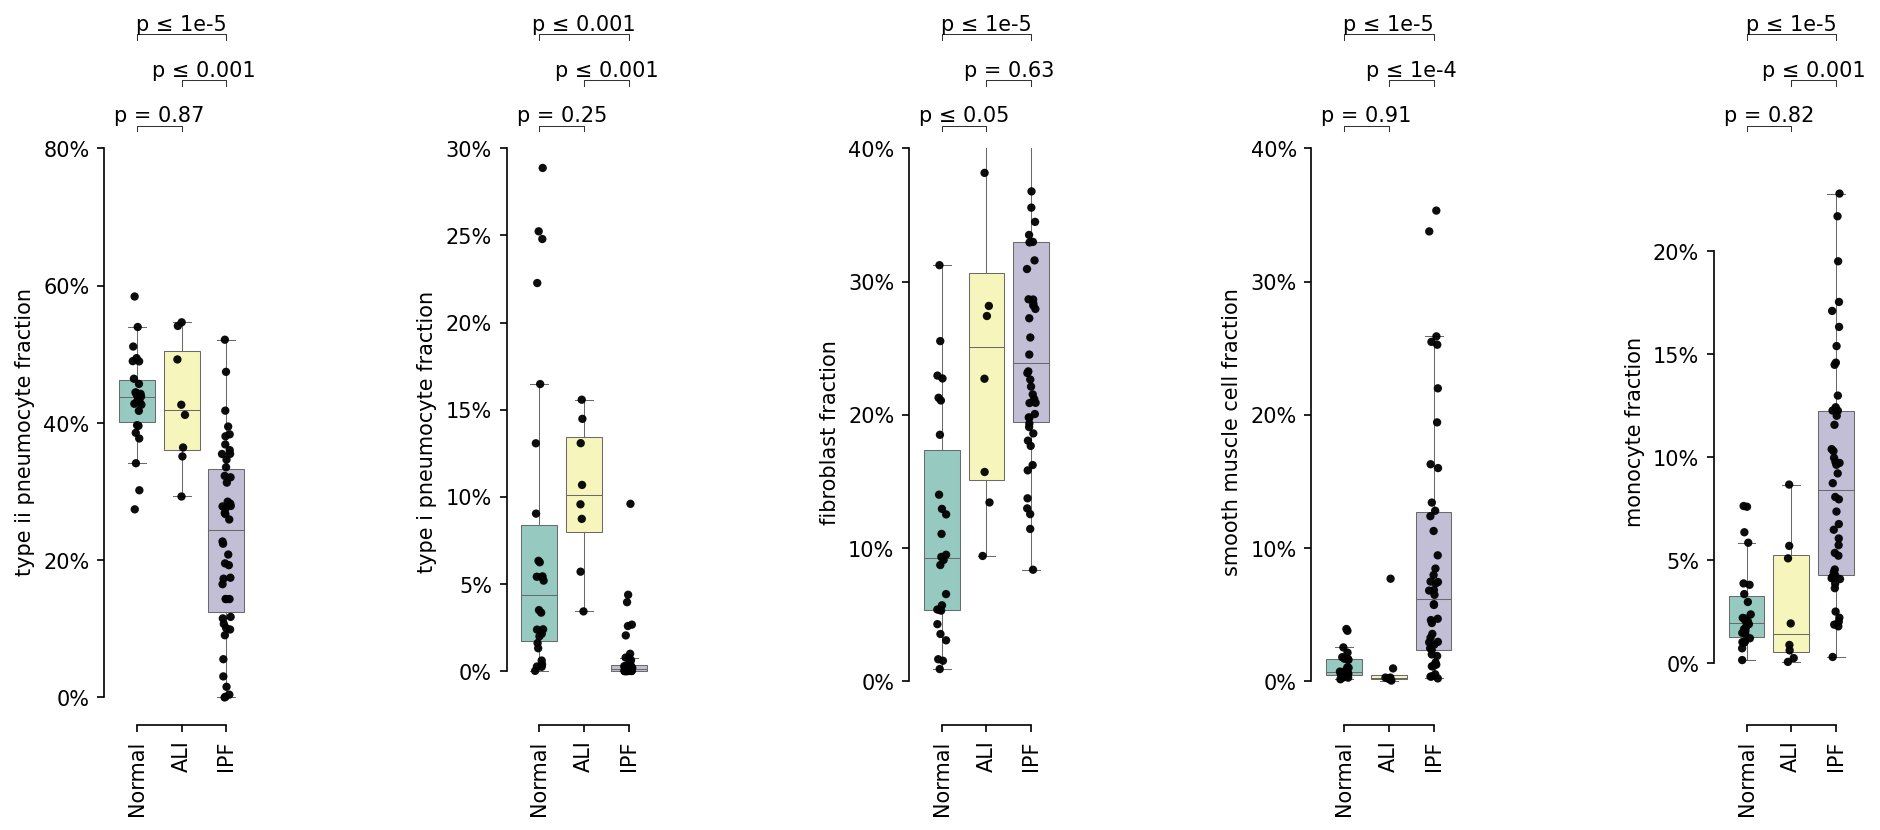

In [17]:
celltypes = ['type ii pneumocyte', 'type i pneumocyte', 'fibroblast', 'smooth muscle cell','monocyte']
group_key = 'DiseaseStatus'
pairs = [('Normal','ALI'), ('Normal','IPF'), ('ALI', 'IPF')]
order = ['Normal', 'ALI', 'IPF']
ucd_key = 'ucdeconvolve_results'
ucd_category = 'primary'
ylims = [0.8, 0.3, 0.4, 0.4, 0.25]
stepsizes = [0.2, 0.05, 0.1, 0.1, 0.05]

with ucd.pl.FigContext(rows = 1, columns = len(celltypes), figsize = (3,5), 
                       dpi = 150, despine = True, gridspec_kw={'wspace':2}) as axes:
    
    for ax, celltype, ylim, stepsize in zip(axes, celltypes, ylims, stepsizes):
        ucd.pubscripts.fig5.plot_grouped_predictions(adata, celltype, group_key,
                                 ucd_key, ucd_category, order, pairs, ax,
                                ylims = (-0.025, ylim), stepsize = stepsize)
        
    
    axes[0].get_figure().savefig("results/figure5_B.png", dpi = 300)

## Supplement Panel A

In [6]:
# Reload results data
adata = sc.read_h5ad("data/IPF/adata_ipf_preds_expl.h5ad")

# Collect explanations
expl_ipf = ucd.tl.read_explanations_from_anndata(adata)

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(10, 3)


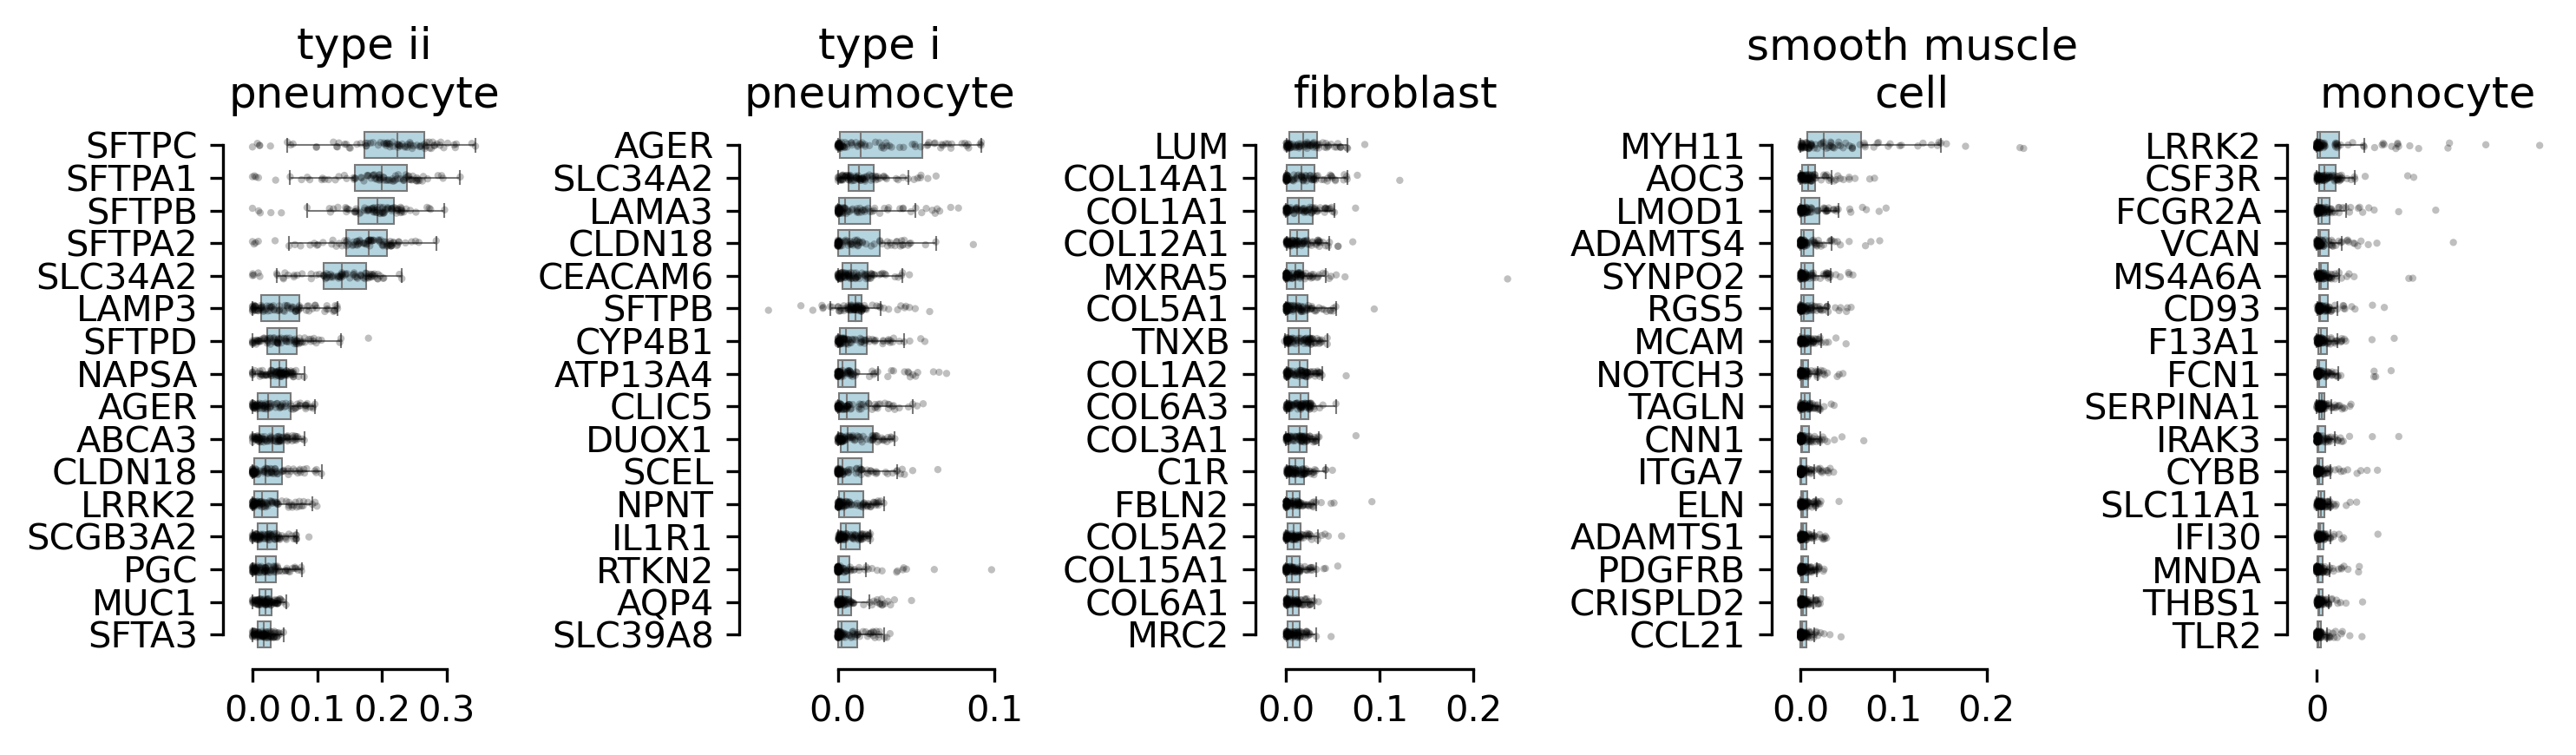

In [7]:
import textwrap

celltypes = expl_ipf.index.get_level_values(0).unique().tolist()


with ucd.pl.FigContext(rows = 1, columns = len(celltypes), figsize = (2,3), 
                       dpi = 300, despine=True) as axes:
    
    for celltype, ax in zip(celltypes, axes):
        simple_name = textwrap.fill(celltype.title().replace("Ii","II"), 16)
        
        ucd.pl.explain(expl_ipf, celltype, ax = ax, point_size = 2)
        ax.set_title(simple_name.lower())
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
        
    # Save figure
    ax.get_figure().savefig("results/supplement5_A.png", dpi = 300)

# Type II Diabetes

## Download & Process Data

In [ ]:
%%bash
cd /home/jupyter/manuscript/figure5/data/T2D/

# Download
aria2c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE50nnn/GSE50244/suppl/GSE50244_Genes_counts_TMM_NormLength_atLeastMAF5_expressed.txt.gz

In [123]:
data = pd.read_table("data/T2D/GSE50244_Genes_counts_TMM_NormLength_atLeastMAF5_expressed.txt.gz")
data = data.rename(columns = {'id' : 'gene_symbol'}).set_index('gene_symbol')

metadata = ucd.pubscripts.fig5.extract_metadata("GSE50244", "characteristics_ch1")
data.columns = metadata.index
data = data.T

metadata.index.name = 'sample_id'
data.index.name = 'sample_id'

In [147]:
adata = anndata.AnnData(data, obs = metadata)
adata.obs.hba1c = adata.obs.hba1c.astype(np.float32)
adata = adata[~adata.obs.hba1c.isna()]

adata.obs['DiseaseStatus'] = 'Unknown'
adata.obs.loc[adata.obs.hba1c.lt(5.7), 'DiseaseStatus'] = 'Normal'
adata.obs.loc[adata.obs.hba1c.between(5.7, 6.4), 'DiseaseStatus'] = 'Pre-Diabetes'
adata.obs.loc[adata.obs.hba1c.gt(6.4), 'DiseaseStatus'] = 'Diabetes'

Trying to set attribute `.obs` of view, copying.


In [ ]:
# Perform deconvolution
ucd.tl.deconvolve(adata, basemodel, split = True, propagate = True, return_results=False)

# Save results
adata.write_h5ad("data/T2D/adata_t2d_preds.h5ad")

## Explanations

In [291]:
#Reload
adata = sc.read_h5ad("data/T2D/adata_t2d_preds.h5ad")

# Define celltypes
celltypes = ['type b pancreatic cell', 'pancreatic a cell', 'pancreatic acinar cell',
             'pancreatic ductal cell','pancreatic d cell', 'pp cell']

# Run explanations
expl_t2d = ucd.tl.explain(adata, celltypes, basemodel, batchsize = 4)

# Save explanation to anndata
ucd.tl.write_explanations_to_anndata(adata, expl_t2d)

# Save results
adata.write_h5ad("data/T2D/adata_t2d_preds_expl.h5ad")

Explaining Batches | 100% (19 of 19) |###| Elapsed Time: 0:00:16 Time:  0:00:16


## Panel D

In [18]:
adata = sc.read_h5ad("data/T2D/adata_t2d_preds_expl.h5ad")

(15, 5)
Normal vs. Pre-Diabetes: Welch's t-test independent samples, P_val:1.149e-01 t=1.608e+00
Pre-Diabetes vs. Diabetes: Welch's t-test independent samples, P_val:8.836e-02 t=1.777e+00
Normal vs. Diabetes: Welch's t-test independent samples, P_val:3.527e-03 t=3.438e+00
Normal vs. Pre-Diabetes: Welch's t-test independent samples, P_val:7.987e-01 t=2.562e-01
Pre-Diabetes vs. Diabetes: Welch's t-test independent samples, P_val:6.226e-01 t=4.978e-01
Normal vs. Diabetes: Welch's t-test independent samples, P_val:4.369e-01 t=7.910e-01
Normal vs. Pre-Diabetes: Welch's t-test independent samples, P_val:9.154e-01 t=1.067e-01
Pre-Diabetes vs. Diabetes: Welch's t-test independent samples, P_val:1.627e-01 t=-1.445e+00
Normal vs. Diabetes: Welch's t-test independent samples, P_val:1.640e-01 t=-1.450e+00
Normal vs. Pre-Diabetes: Welch's t-test independent samples, P_val:6.502e-02 t=-1.889e+00
Pre-Diabetes vs. Diabetes: Welch's t-test independent samples, P_val:7.357e-01 t=3.412e-01
Normal vs. Dia

/home/jupyter/github_repos/ucdeconvolve_old/ucdeconvolve/_plotting.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


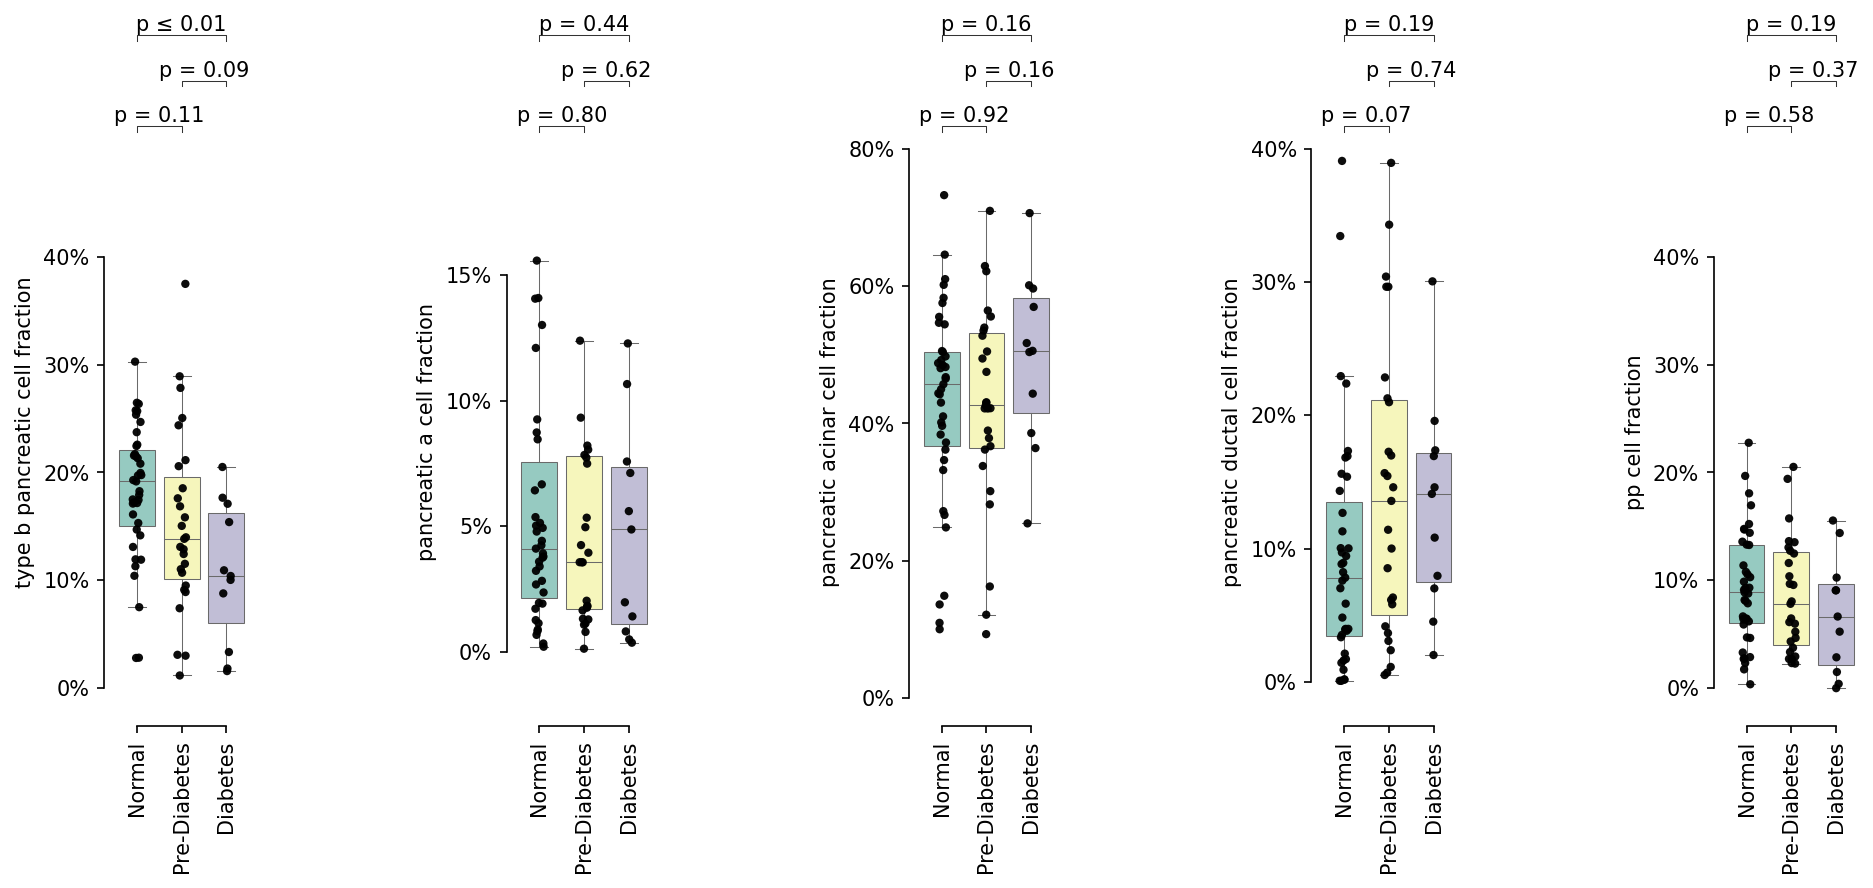

In [19]:
celltypes = ['type b pancreatic cell', 'pancreatic a cell', 'pancreatic acinar cell',
             'pancreatic ductal cell','pp cell']

group_key = 'DiseaseStatus'
pairs = [('Normal','Pre-Diabetes'), ('Normal','Diabetes'), ('Pre-Diabetes', 'Diabetes')]
order = ['Normal', 'Pre-Diabetes', 'Diabetes']
ucd_key = 'ucdeconvolve_results'
ucd_category = 'primary'
ylims = [0.5, 0.2, 0.8, 0.4, 0.5]
stepsizes = [0.1, 0.05, 0.2, 0.1, 0.1]

with ucd.pl.FigContext(rows = 1, columns = len(celltypes), figsize = (3,5), 
                       dpi = 150, despine = True, gridspec_kw={'wspace':2}) as axes:
    
    for ax, celltype, ylim, stepsize in zip(axes, celltypes, ylims, stepsizes):
        ucd.pubscripts.fig5.plot_grouped_predictions(adata, celltype, group_key,
                                 ucd_key, ucd_category, order, pairs, ax,
                                ylims = (-0.025, ylim), stepsize = stepsize)
        
    
    axes[0].get_figure().savefig("results/figure5_D.png", dpi = 300)

## Supplement Panel B

In [10]:
# Reload results data
adata = sc.read_h5ad("data/T2D/adata_t2d_preds_expl.h5ad")

# Collect explanations
expl_t2d = ucd.tl.read_explanations_from_anndata(adata)

(12, 3)


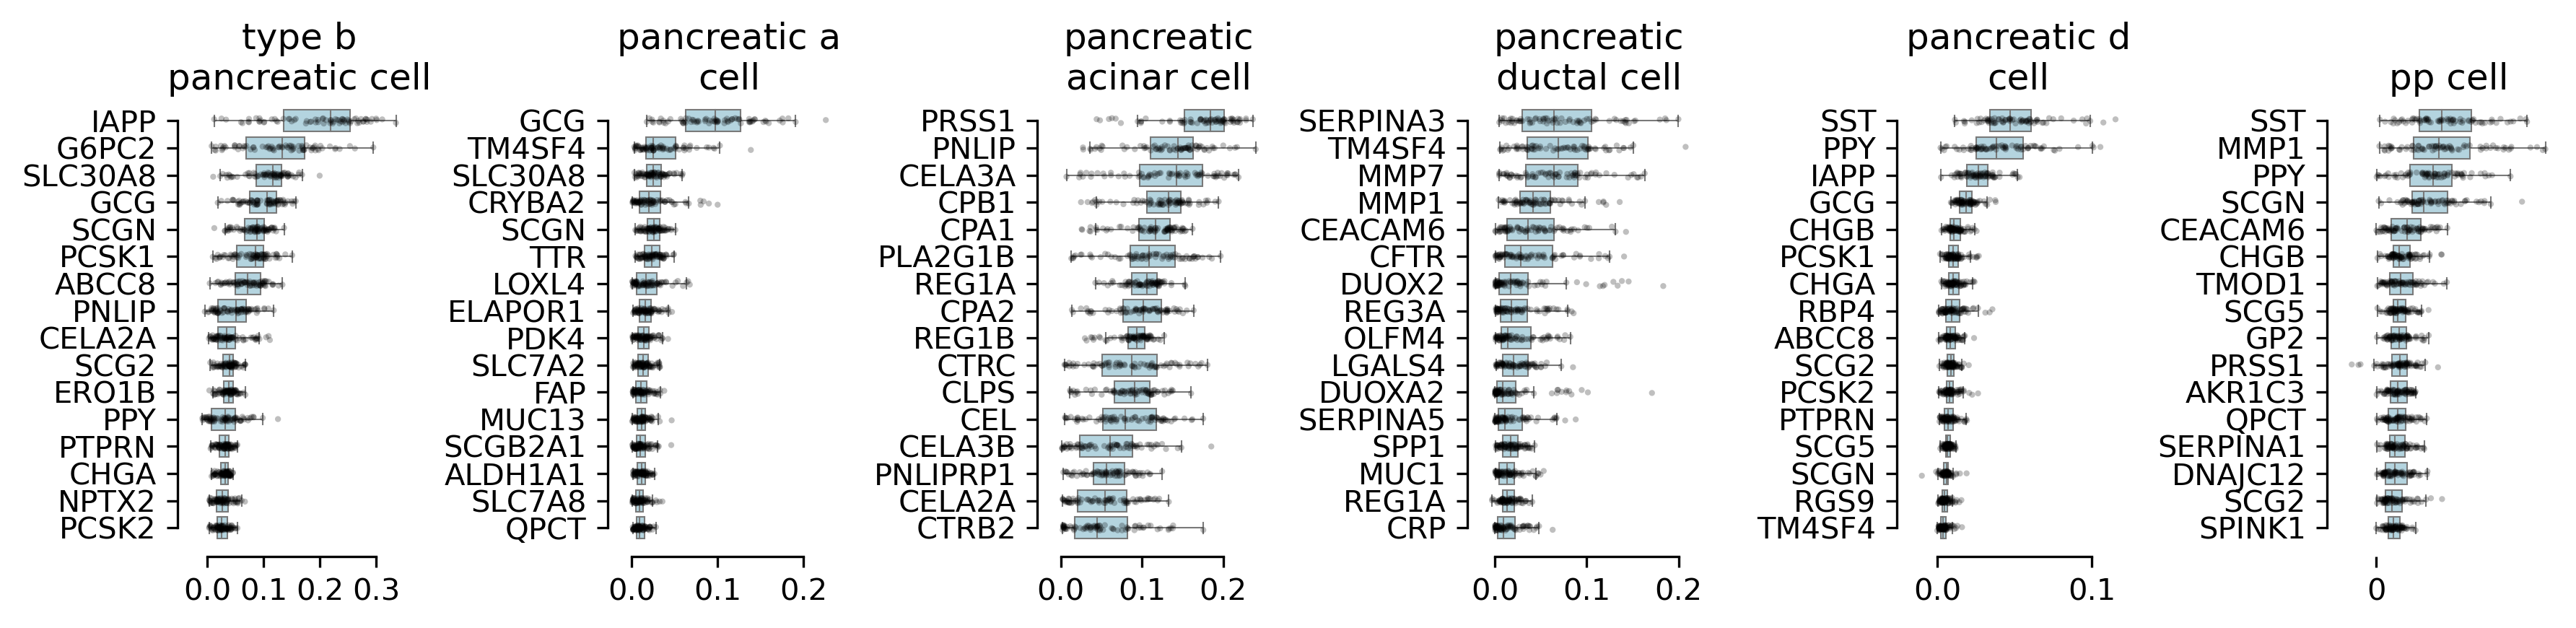

In [11]:
import textwrap

celltypes = expl_t2d.index.get_level_values(0).unique().tolist()


with ucd.pl.FigContext(rows = 1, columns = len(celltypes), figsize = (2,3), 
                       dpi = 300, despine=True) as axes:
    
    for celltype, ax in zip(celltypes, axes):
        simple_name = textwrap.fill(celltype.title().replace("Pp","PP"), 16)
        
        ucd.pl.explain(expl_t2d, celltype, ax = ax, point_size = 2)
        ax.set_title(simple_name.lower())
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
        
    # Save figure
    ax.get_figure().savefig("results/supplement5_B.png", dpi = 300)

## Extended Analysis Supplement 5-II: Beta Cell vs. Age Correlations

In [3]:
adata = sc.read_h5ad("data/T2D/adata_t2d_preds_expl.h5ad")
preds = ucd.utils.get_deconv_as_df(adata)

In [4]:
beta_cells = preds['type b pancreatic cell'].to_frame()
beta_cells[['age','bmi','gender']] = adata.obs[['age','bmi','gender']].values
beta_cells['DiseaseStatus'] = adata.obs['DiseaseStatus'].values

beta_cells['age'] = beta_cells['age'].astype(np.float32)
beta_cells['bmi'] = beta_cells['bmi'].astype(np.float32)

beta_cells['age_groups'] = pd.cut(beta_cells['age'],3, labels=['Young','Middle','Older'])

In [ ]:
from statannot

(2.5, 4)
Normal vs. Pre-Diabetes: Welch's t-test independent samples, P_val:3.270e-03 t=-3.057e+00
Pre-Diabetes vs. Diabetes: Welch's t-test independent samples, P_val:9.018e-01 t=1.256e-01
Normal vs. Diabetes: Welch's t-test independent samples, P_val:7.838e-02 t=-1.866e+00


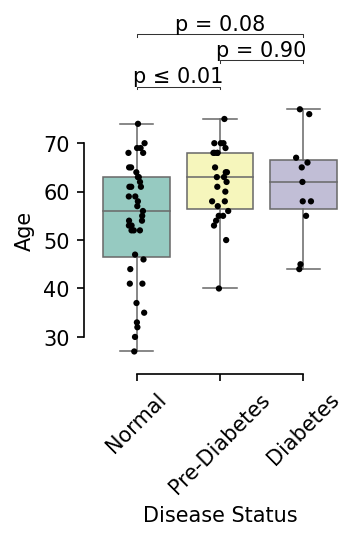

In [15]:
df = beta_cells
x = 'DiseaseStatus'
y = 'age'
order = ['Normal', 'Pre-Diabetes', 'Diabetes']
pairs = [('Normal', 'Pre-Diabetes'), ('Normal', 'Diabetes'), ('Pre-Diabetes', 'Diabetes')]
with ucd.pl.FigContext(dpi = 150, figsize = (2.5,4), despine = True) as ax:

    sns.boxplot(data = df, x = 'DiseaseStatus', y = 'age', 
                palette = 'Set3', order = order, linewidth=0.75)
    sns.stripplot(data = df, x = x, order = order,
                y = y, color = 'k', s = 3)
    
    ax.set_xlabel("Disease Status")
    ax.set_ylabel("Age")
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax.xaxis.set_tick_params(which = 'both', rotation = 45)
    
    annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
    annotator.configure(test='t-test_welch', text_format='simple', 
                        loc='outside', comparisons_correction = None,
                       line_offset = 0.01, show_test_name = False,
                       line_height = 0.01, line_width = 0.5,
                       text_offset = 0)
    annotator.apply_and_annotate()

(4, 4)


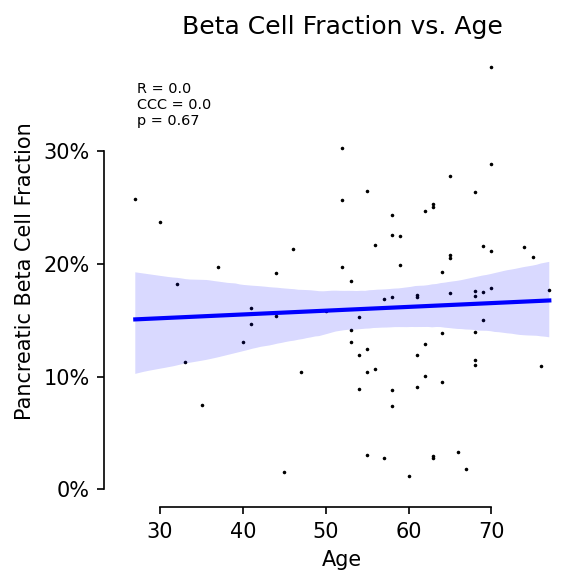

In [29]:
with ucd.pl.FigContext(dpi = 150, figsize = (4,4), despine = True) as ax:
    ucd.pl.scatter(beta_cells, 'age', 'type b pancreatic cell', draw_identity = False, ax = ax,
                      regline_color = 'b', lw = 2)
    
    ax.set_xlabel("Age")
    ax.set_ylabel("Pancreatic Beta Cell Fraction")
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0, 0))
    ax.set_title("Beta Cell Fraction vs. Age")

# Oligodendrocyte

## Download & Process Data

In [156]:
%%bash

cd /home/jupyter/manuscript/figure5/data/MS/

aria2c https://ftp.ncbi.nlm.nih.gov/geo/series/GSE138nnn/GSE138614/suppl/GSE138614_countMatrix.txt.gz


03/24 17:07:53 [NOTICE] Downloading 1 item(s)

03/24 17:07:53 [NOTICE] Download complete: /home/jupyter/manuscript/figure5/GSE138614_countMatrix.txt.gz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
98f35a|OK  |    25MiB/s|/home/jupyter/manuscript/figure5/GSE138614_countMatrix.txt.gz

Status Legend:
(OK):download completed.


bash: line 2: cd: /home/jupyter/manuscript/figure5/MS/: No such file or directory


In [183]:
data = pd.read_table("data/MS/GSE138614_countMatrix.txt.gz")
data = data.rename(columns = {'Unnamed: 0' : 'gene_symbol'}).set_index('gene_symbol')

genes = ucd.utils.match_to_gene(data.index.tolist())
data.index = genes

data = data[~data.index.isna()]
data = data[~data.index.duplicated()]
data = data.T

metadata = ucd.pubscripts.fig5.extract_metadata("GSE138614", "characteristics_ch1")
data.index = metadata.index

In [195]:
adata = anndata.AnnData(data, obs = metadata)
adata.obs['DiseaseStatus'] = adata.obs.diagnosis.map({'Multiplesclerosis' : 'MS',
                                                     'Control' : 'Healthy'}) + " " + \
                            adata.obs.lesiontype.str.replace("("," (")

adata.obs['DiseaseStatus'] = adata.obs['DiseaseStatus'].str.replace("Whitematter", "White Matter")\
                        .str.replace("Chronicactive", "Chronic Active")\
                        .str.replace("Normalappearingwhitematter", "Normal Appearing White Matter")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


In [ ]:
adata.write_h5ad("data/MS/adata_ms.h5ad")

In [198]:
adata = sc.read_h5ad("data/MS/adata_ms.h5ad")

In [199]:
# Perform deconvolution
ucd.tl.deconvolve(adata, basemodel, split = True, propagate = True, return_results=False)

# Save results
adata.write_h5ad("data/MS/adata_ms_preds.h5ad")

/home/jupyter/github_repos/ucdeconvolve/_propagator.py:233: FutureWarning: The default value of regex will change from True to False in a future version.
  'kidney loop of henle thick ascending limb epithelial cell')\


## Explanations

In [252]:
#Reload

adata = sc.read_h5ad("data/MS/adata_ms_preds.h5ad")

# Define celltypes
celltypes = ['oligodendrocyte', 'neural progenitor cell', 'immature astrocyte',
             'l2/3-6 intratelencephalic projecting glutamatergic cortical neuron']

# Run explanations
expl_ms = ucd.tl.explain(adata, celltypes, basemodel, batchsize = 4)

# Save explanation to anndata
ucd.tl.write_explanations_to_anndata(adata, expl_ms)

# Save results
adata.write_h5ad("data/MS/adata_ms_preds_expl.h5ad")

## Panel F

In [20]:
adata = sc.read_h5ad("data/MS/adata_ms_preds_expl.h5ad")
adata.obs.DiseaseStatus = adata.obs.DiseaseStatus.str.split(" \(").str[0]\
    .str.replace("White Matter", "WM")\
    .str.replace("Normal Appearing WM", "Normal-Looking")

(16, 5)
Healthy WM vs. MS Normal-Looking: Welch's t-test independent samples, P_val:5.340e-02 t=1.989e+00
Healthy WM vs. MS Active: Welch's t-test independent samples, P_val:1.795e-05 t=4.954e+00
Healthy WM vs. MS Normal-Looking: Welch's t-test independent samples, P_val:8.436e-01 t=-1.985e-01
Healthy WM vs. MS Active: Welch's t-test independent samples, P_val:6.611e-01 t=4.432e-01
Healthy WM vs. MS Normal-Looking: Welch's t-test independent samples, P_val:9.061e-01 t=1.188e-01
Healthy WM vs. MS Active: Welch's t-test independent samples, P_val:1.781e-02 t=-2.617e+00
Healthy WM vs. MS Normal-Looking: Welch's t-test independent samples, P_val:1.212e-01 t=-1.598e+00
Healthy WM vs. MS Active: Welch's t-test independent samples, P_val:2.871e-01 t=-1.082e+00


/home/jupyter/github_repos/ucdeconvolve_old/ucdeconvolve/_plotting.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


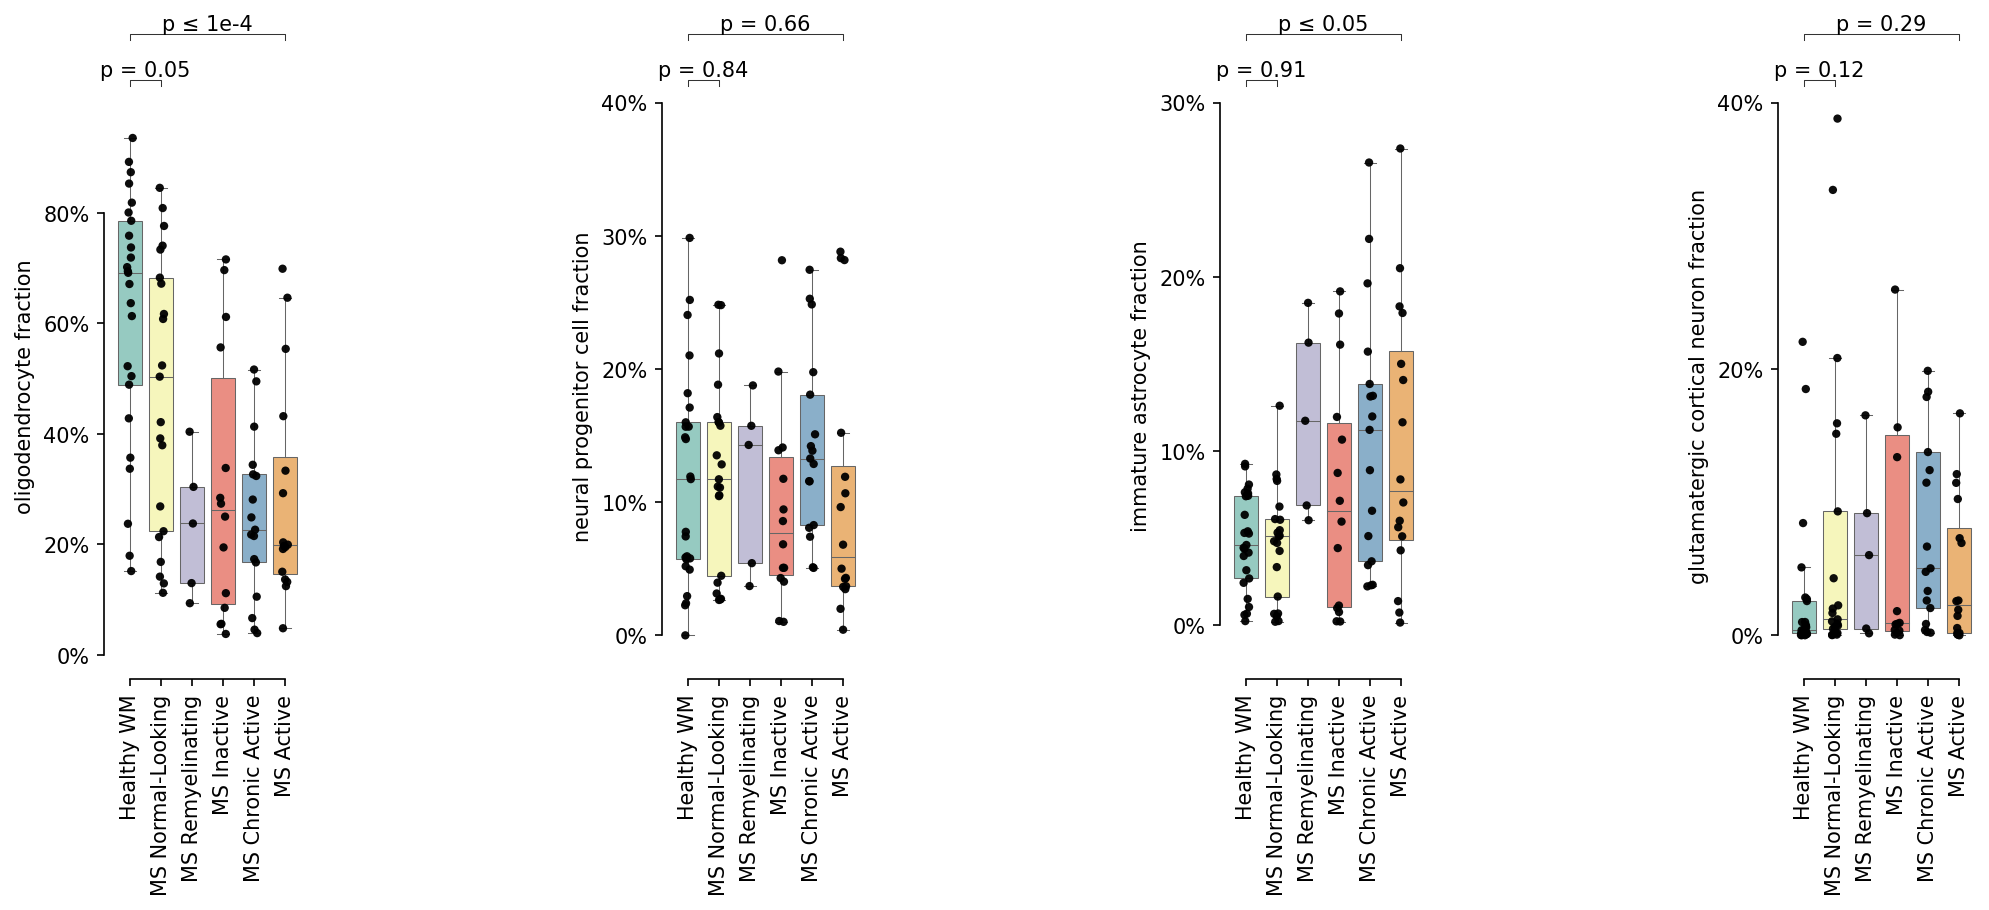

In [21]:
celltypes = ['oligodendrocyte', 'neural progenitor cell', 'immature astrocyte',
             'l2/3-6 intratelencephalic projecting glutamatergic cortical neuron']

group_key = 'DiseaseStatus'
pairs = [('Healthy WM','MS Active'), ('Healthy WM', 'MS Normal-Looking')]

order = ['Healthy WM', 'MS Normal-Looking', 
         'MS Remyelinating', 'MS Inactive','MS Chronic Active', 'MS Active']

ucd_key = 'ucdeconvolve_results'
ucd_category = 'primary'
ylims = [1.0, 0.4, 0.3, 0.4]
stepsizes = [0.2, 0.1, 0.1, 0.2]

with ucd.pl.FigContext(rows = 1, columns = len(celltypes), figsize = (4,5), 
                       dpi = 150, despine = True, gridspec_kw={'wspace':2}) as axes:
    
    for ax, celltype, ylim, stepsize in zip(axes, celltypes, ylims, stepsizes):
        ucd.pubscripts.fig5.plot_grouped_predictions(adata, celltype, group_key,
                                 ucd_key, ucd_category, order, pairs, ax,
                                ylims = (-0.025, ylim), stepsize = stepsize)
        
        if celltype == 'l2/3-6 intratelencephalic projecting glutamatergic cortical neuron':
            ax.set_ylabel("glutamatergic cortical neuron fraction")
    axes[0].get_figure().savefig("results/figure5_F.png", dpi = 300)

## Supplement Panel C

In [14]:
# Reload results data
adata = sc.read_h5ad("data/MS/adata_ms_preds_expl.h5ad")

# Collect explanations
expl_ms = ucd.tl.read_explanations_from_anndata(adata)

(8, 3)


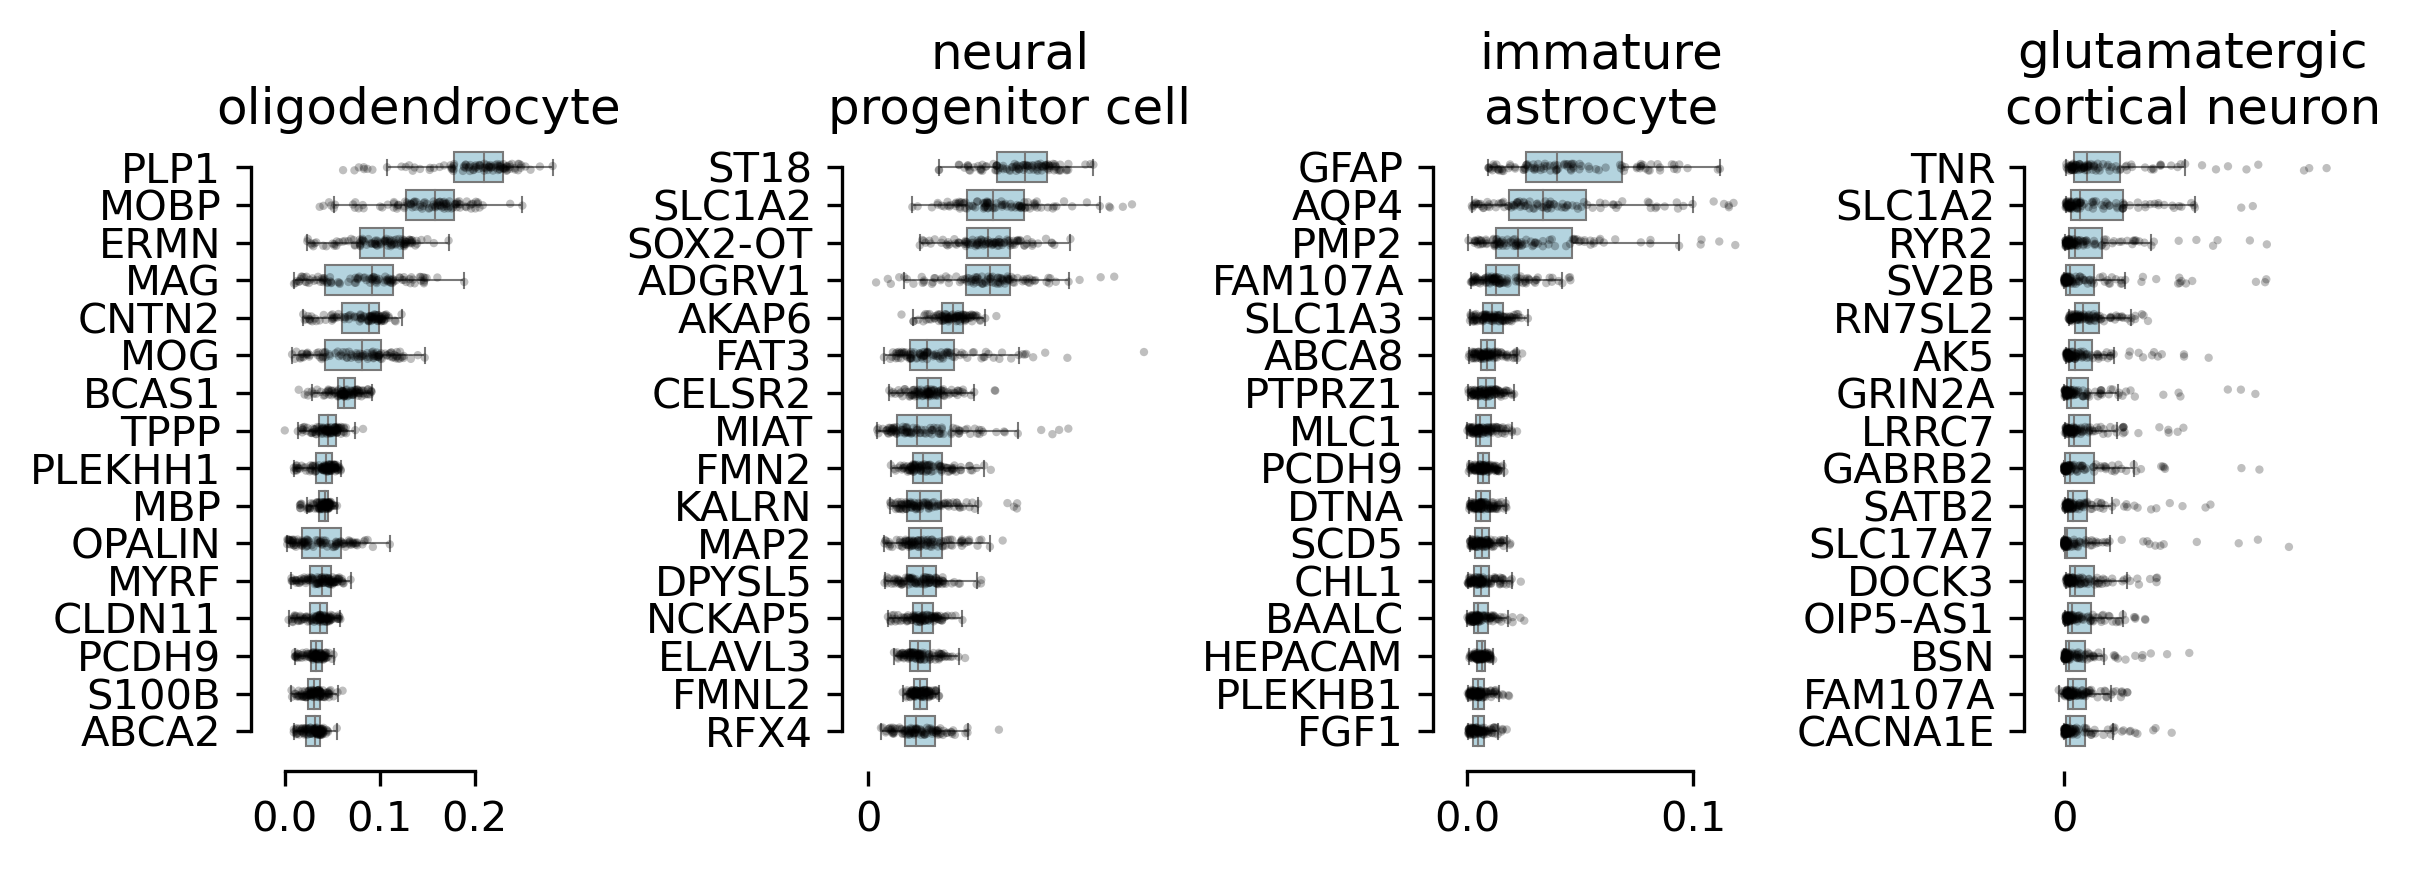

In [15]:
import textwrap

celltypes = expl_ms.index.get_level_values(0).unique().tolist()


with ucd.pl.FigContext(rows = 1, columns = len(celltypes), figsize = (2,3), 
                       dpi = 300, despine=True) as axes:
    
    for celltype, ax in zip(celltypes, axes):
        
        if celltype == "l2/3-6 intratelencephalic projecting glutamatergic cortical neuron":
            simple_name = "glutamatergic cortical neuron"
            simple_name = textwrap.fill(simple_name.title().replace("Pp","PP"), 16)
        else:
            simple_name = textwrap.fill(celltype.title().replace("Pp","PP"), 16)
        
        
        
        ucd.pl.explain(expl_ms, celltype, ax = ax, point_size = 2)
        ax.set_title(simple_name.lower())
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
        
    # Save figure
    ax.get_figure().savefig("results/supplement5_C.png", dpi = 300)